In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

import dask

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

# **Water Permamency**


Import required DC utils

In [3]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter

Define aoi via wkt polygon (could be subbed or shapefile)

In [4]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [5]:
#set baseline start and end of period
start_date = '2019-1-1'
end_date = '2019-4-1'
res = (30)

In [6]:
dc = datacube.Datacube(app="water permamency")

In [7]:
dask_chunks=dict(
    x=1000,
    y=1000
)

In [8]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
#create resolution
resolution = (-res, res)

In [11]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

### Load Data

Generic query specs

In [12]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = baseline_time_period,
                resolution = resolution,
                group_by = 'solar_day',
                dask_chunks = dask_chunks
            )


Dataset-specifics

In [13]:
ds_s1 = dc.load(product='s1g_gamma0_scene',
              **query)

In [14]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

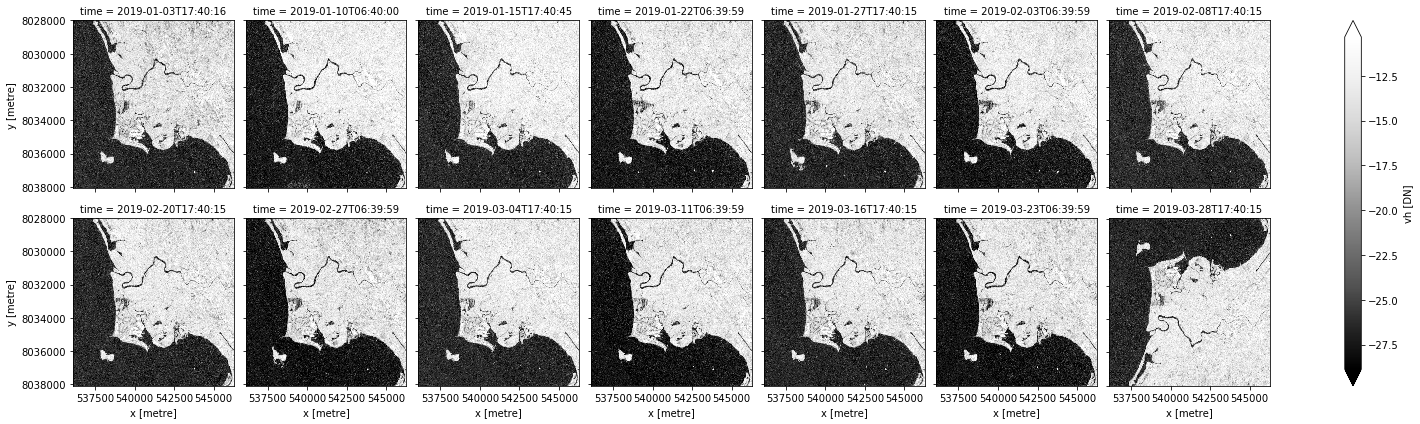

In [15]:
ds_s1.vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

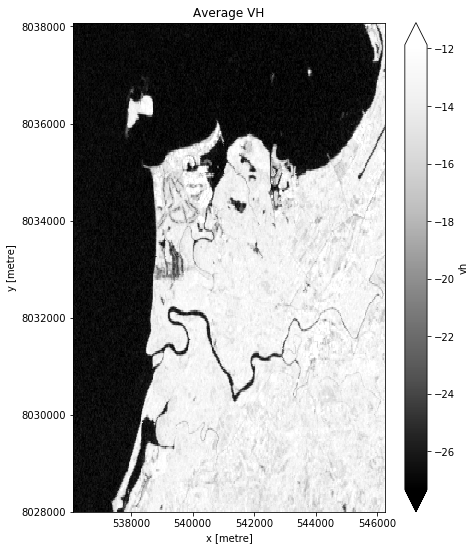

In [16]:
# Plot the average of all VH observations
mean_vh = ds_s1.vh.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average VH")
plt.show()

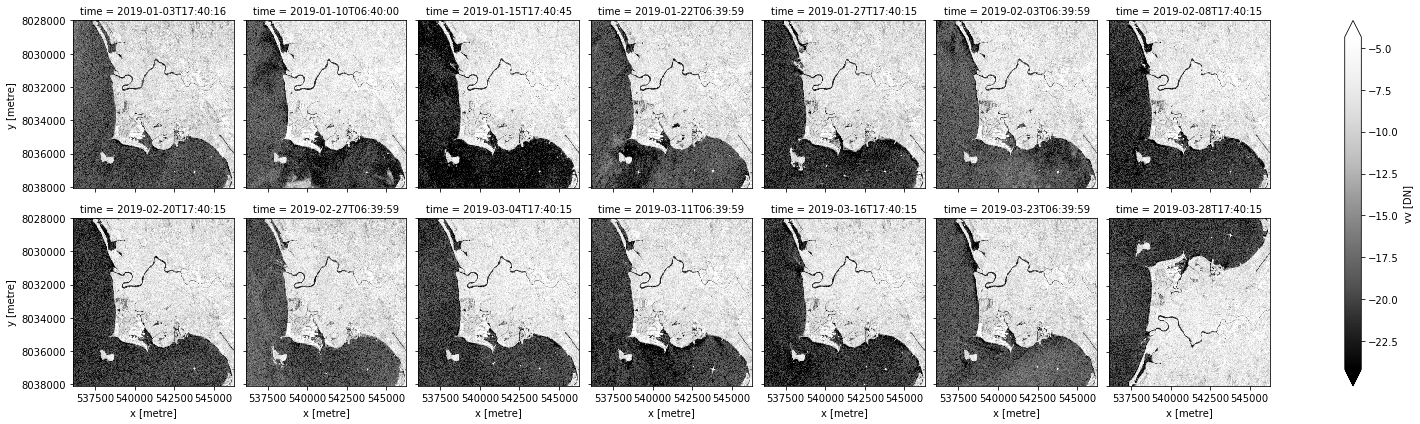

In [17]:
# Plot all VV observations for the year
ds_s1.vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

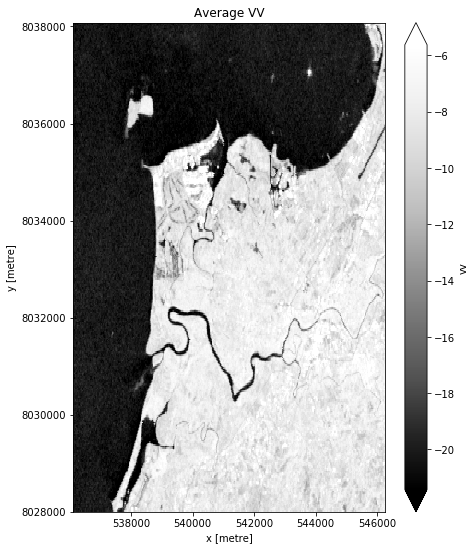

In [18]:
# Plot the average of all VV observations
mean_vv = ds_s1.vv.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average VV")
plt.show()

In [20]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [21]:
# Set any null values to 0 before applying the filter to prevent issues
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)


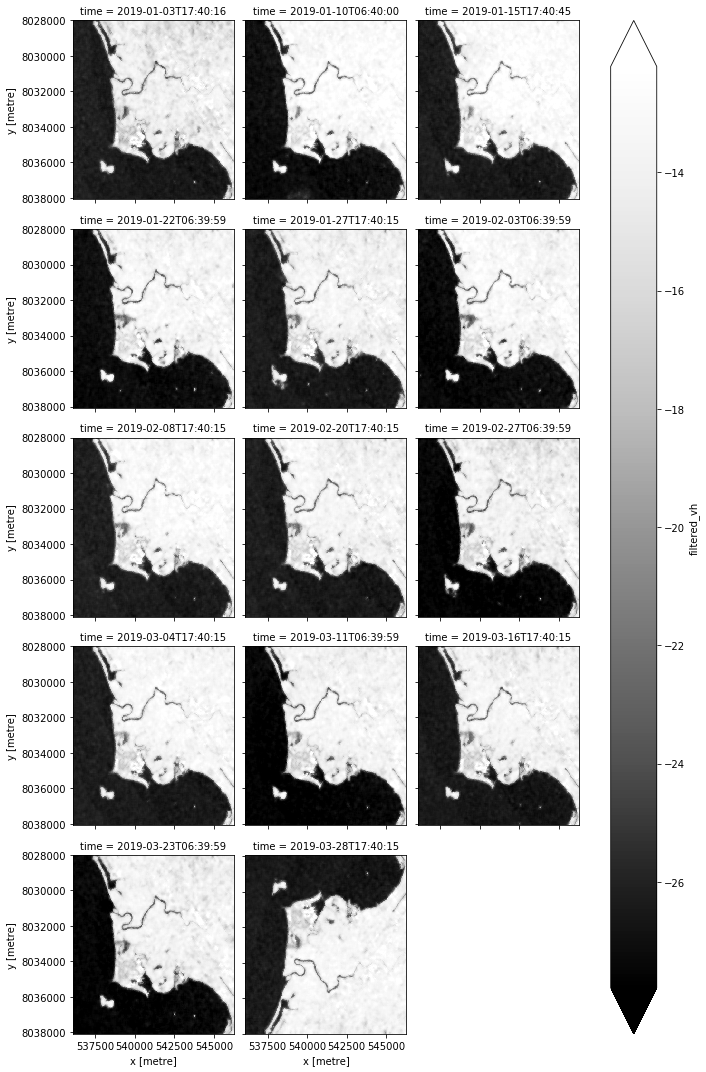

In [66]:
# Plot all filtered VH observations for the year
ds_s1.filtered_vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3)
plt.show()

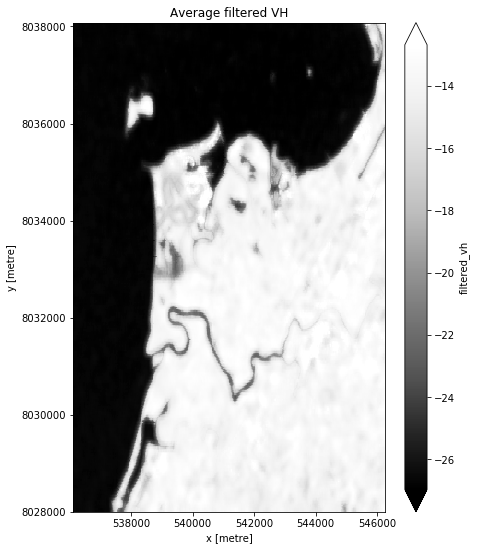

In [23]:
# Plot the average of all filtered VH observations
mean_filtered_vh = ds_s1.filtered_vh.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_filtered_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VH")
plt.show()

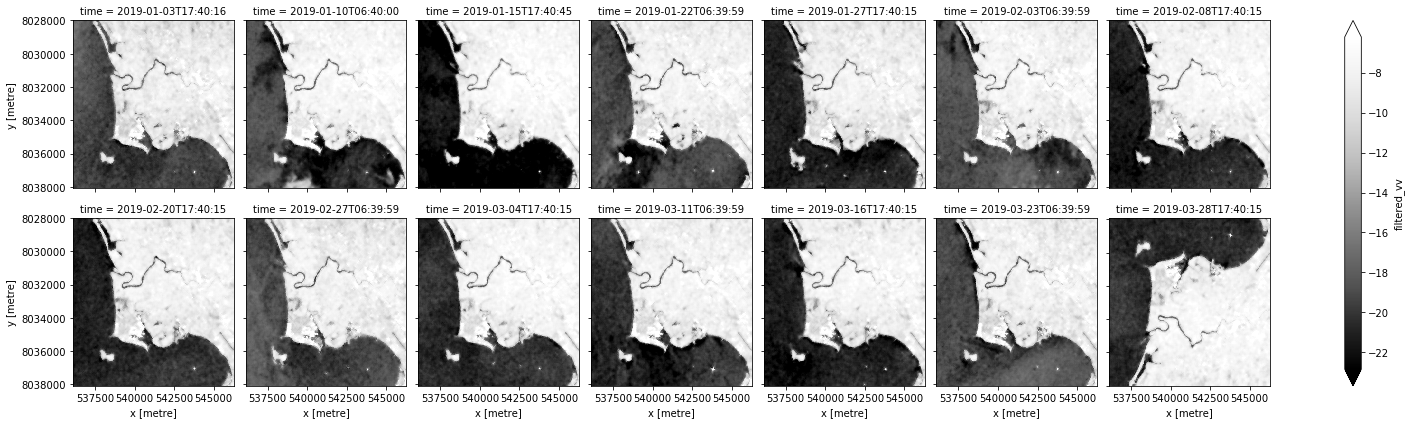

In [24]:
# Plot all filtered VV observations for the year
ds_s1.filtered_vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

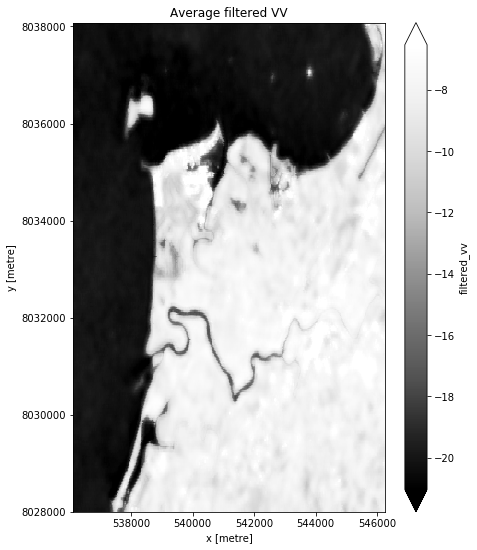

In [25]:
# Plot the average of all filtered VV observations
mean_filtered_vv = ds_s1.filtered_vv.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_filtered_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VV")
plt.show()

## Plot Histograms

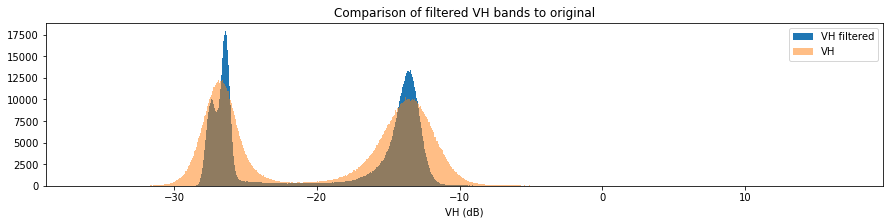

In [26]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

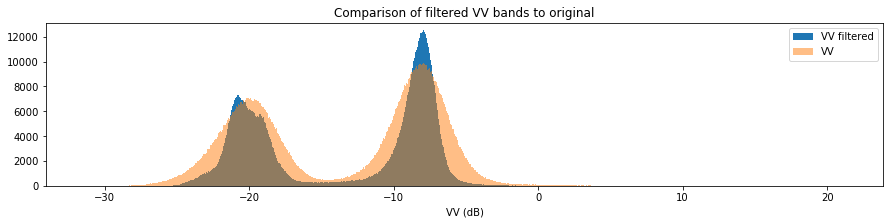

In [27]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv.plot.hist(bins=1000, label="VV filtered")
ds_s1.vv.plot.hist(bins=1000, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

In [62]:
def s1_water_classifier(ds, threshold=-20.0):
    filtered = ds.vh.groupby("time").apply(lee_filter, size=7)
    water_data_array = filtered < threshold
    return water_data_array.to_dataset(name="s1_water")

In [63]:
ds_s1["water"] = s1_water_classifier(ds_s1).s1_water

In [64]:
print(ds_s1.water)

<xarray.DataArray 'water' (time: 14, y: 336, x: 339)>
array([[[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       ...,

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-03T17:40:16 ... 2019-03-28T17:40:15
  * y        (y) float64 8.038e+06 8.038e+06 8.038e+06 ... 8.028e+06 8.028e+06
  * x        (

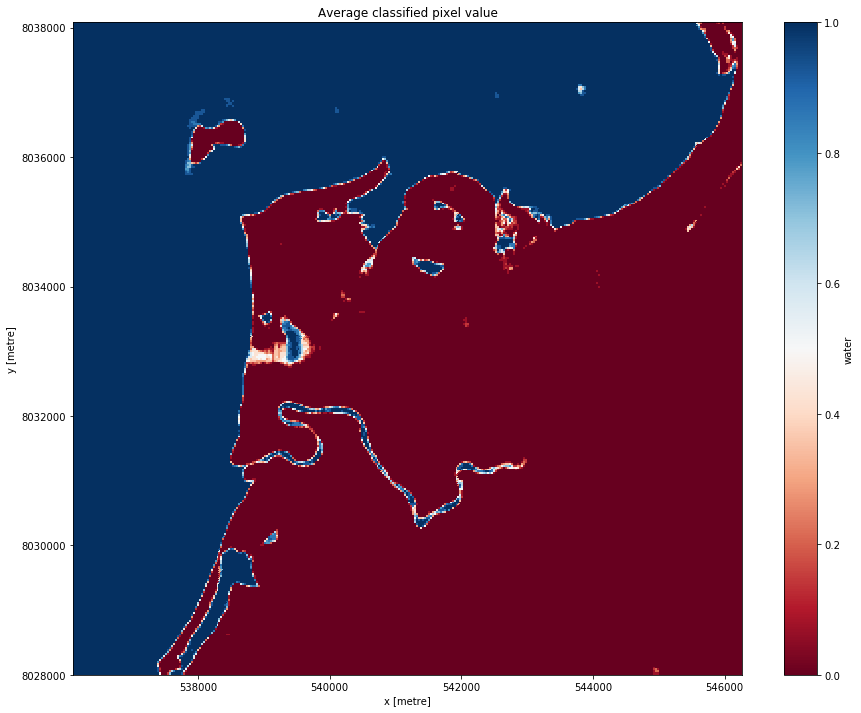

In [65]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(15, 12))
ds_s1.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

In [22]:
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter
if is_dataset_empty(dsS1):
    print('no S1 images for this time and area')
else:
    s1water = dask.delayed(createS1water(dsS1))
    s1water_comp = s1water.compute()
    

KeyboardInterrupt: 

In [ ]:
s1water_comp.water.mean(dim = 'time').plot();

In [ ]:
#s1_coverage.wofs.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [ ]:
if is_dataset_empty(dsS2):
    print('invalid')
else:
    good_quality = (
            (dsS2.scene_classification != 0) & # mask out NO_DATA
            (dsS2.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (dsS2.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (dsS2.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (dsS2.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (dsS2.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (dsS2.scene_classification != 10)&  # mask out THIN_CIRRUS
            (dsS2.scene_classification != 11)  # mask out SNOW
        )
    water_classes = dask.delayed(wofs_classify)(dsS2, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    waterS2 = dask.delayed(water_classes.rename({'wofs': 'water'}))
    waterS2_comp = waterS2.compute()
    

In [ ]:
waterL8_comp = waterL8.compute()
waterL7_comp = waterL7.compute()
waterL5_comp = waterL5.compute()
waterL4_comp = waterL4.compute()

In [ ]:
merged = xr.Dataset.merge(waterL4_comp, waterL8_comp, waterL7_comp, waterL5_comp)

In [ ]:
if is_dataset_empty(dsS2):
    print('stick with L8 only merge')
else:
    merged = xr.Dataset.merge(waterS2_comp, merged)

In [ ]:
if is_dataset_empty(dsS1):
    print('stick with L8/S2 only merge')
else:
    merged = xr.Dataset.merge(s1water_comp, merged)

In [ ]:
water_composite_mean = merged.water.mean(dim='time')

In [ ]:
print(merged)

Visualise wofs summary product

In [ ]:
plt.figure(figsize = (10,8), dpi=120)
merged.water.mean(dim = 'time').plot();

In [ ]:
plt.figure(figsize = (10,8), dpi=120)
waterS2_comp.water.mean(dim = 'time').plot();

In [ ]:
plt.figure(figsize = (10,8), dpi=120)
waterL8_comp.water.mean(dim = 'time').plot();

In [ ]:
waterL8_comp.water.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [ ]:
waterS2_comp.water.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)